In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as jrandom
import jax


from seqjax.target.simulate import simulate

In [9]:
from seqjax.target.stochastic_vol import SimpleStochasticVol, LogVolRW, LastUnderlying

num_steps = 100
hyperparameters = LogVolRW(
    std_log_vol=jnp.array(3.2), 
    initial_underlying=jnp.array(3000.0),
    initial_min_vol=jnp.array(0.01),
    initial_max_vol=jnp.array(0.6),
)

key = jrandom.key(22)
dt = jnp.array(1 / (256 * 8 * 60))  # 1 minute in 256 day 8 hr trading days
t_array = dt * jnp.arange(num_steps) # time in years
condition = jax.vmap(LastUnderlying)(jnp.ones(num_steps) * dt) # setup constant dt
target = SimpleStochasticVol()

x_path, observation_path, observed_condition = simulate(
    key,
    target,
    condition,
    hyperparameters,
    num_steps=num_steps,
)

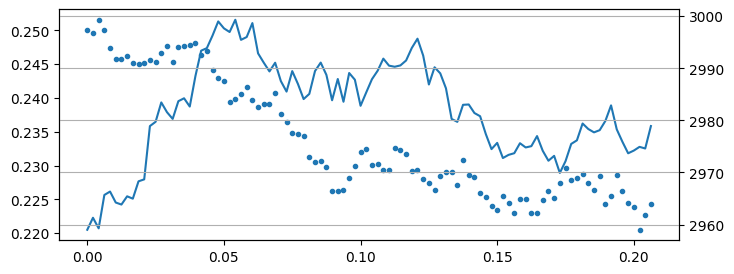

In [11]:
plt.figure(figsize=(8, 3))
plt.plot(t_array * 256, jnp.exp(x_path.last_log_vol))
plt.twinx()
plt.scatter(t_array * 256, observation_path.underlying, marker='.')
plt.grid()

In [5]:
from seqjax.target.evaluate import get_log_p_joint_for_target

log_p_joint = get_log_p_joint_for_target(target)

log_p_joint(
    x_path,
    observation_path,
    observed_condition,
    hyperparameters
)

Array(14.406941, dtype=float32)

In [6]:
from seqjax.target.stochastic_vol import SkewStochasticVol, LogVolWithSkew

x_paths = []
num_days = 2
num_steps = 8 * 60 * num_days
hyperparameters = LogVolWithSkew(
    std_log_vol=jnp.array(6.4), 
    mean_reversion=jnp.array(12.), # revert in a month
    long_term_log_vol=jnp.log(jnp.array(0.16)),
    return_drift=jnp.array(0.),
    skew=jnp.array(-0.8),
    initial_underlying=jnp.array(3000.0),
    initial_min_vol=jnp.array(0.05),
    initial_max_vol=jnp.array(0.30),
)

for seed in range(50):
    key = jrandom.key(seed)
    dt = jnp.array(1 / (256 * 8 * 60))  # 1 minute in 256 day 8 hr trading days
    t_array = dt * jnp.arange(num_steps) # time in years
    condition = jax.vmap(LastUnderlying)(jnp.ones(num_steps) * dt) # setup constant dt
    target = SkewStochasticVol()

    skew_x_path, skew_observation_path, observed_condition = simulate(
        key,
        target,
        condition,
        hyperparameters,
        num_steps=num_steps,
    )

    x_paths.append(skew_x_path)

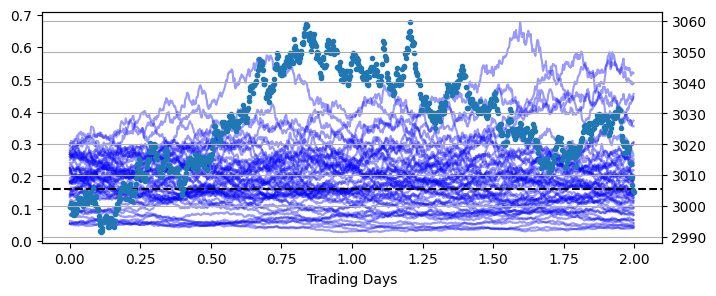

In [7]:
plt.figure(figsize=(8, 3))
for skew_x_path in x_paths:
    plt.plot(t_array * 256, jnp.exp(skew_x_path.last_log_vol), alpha=0.4, c='blue')
plt.axhline(jnp.exp(hyperparameters.long_term_log_vol), c='black', linestyle='--')
plt.xlabel('Trading Days')
plt.twinx()
plt.scatter(t_array * 256, skew_observation_path.underlying, marker='.')
plt.grid()